In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import statsmodels.api as sm

In [6]:
data_folder = "drills_data/"
prices = pd.read_csv(data_folder + "prices.csv")
prices = prices.dropna(subset=['rating'])
print(prices.columns)

Index(['platform', 'website', 'date', 'zipcode', 'rank', 'page', 'query',
       'prod_id', 'upc', 'product', 'manufacturer', 'model', 'price',
       'list_price', 'in_stock', 'max_qty', 'seller', 'arrives', 'shipping',
       'shipping_price', 'shipping_options', 'store_stock', 'store_address',
       'store_zip', 'store_price', 'weight', 'reviews', 'rating', 'quantity1',
       'quantity2', 'quantity3', 'quantity4', 'quantity5', 'ads'],
      dtype='object')


In [7]:
def calc_rank(prices):
    return 22 - (prices['rank'] + (prices['rank'] == 0)*21)

def calc_inven(prices):
    quants = {'AMZN':'quantity3','WMT':'quantity3', 'HD':'quantity1', 'LOW':'quantity1' }
    platforms  = ['AMZN','WMT','HD','LOW']
    inventory = prices['in_stock'].fillna(0)
    
    for plat in platforms:
        inventory[prices['platform']==plat] = prices[quants[plat]][prices['platform']==plat].fillna(0)
    
    inventory = (inventory == 0)*prices['in_stock'].fillna(0)*prices['max_qty'].fillna(0) + inventory

    return inventory
        
        

def calc_promo(prices):
    platforms = ['AMZN','WMT','HD','LOW']
    promo_dict = {'AMZN':'quantity4','WMT':'quantity2', 'HD':'quantity2', 'LOW':'quantity2' }
    promo = 1.*(prices['price'] <= prices['list_price'])
    promo = promo.fillna(0)
    for plat in platforms:
        plat_promo = np.array(prices[promo_dict[plat]][prices['platform']==plat].fillna(0))
        promo[prices['platform']==plat] = np.minimum(plat_promo + promo[prices['platform']==plat],1)
    return promo
    
    
def calc_ship(prices):
    ship = ( prices['arrives'] - prices['date'] )/1e8
    ship = ship.fillna(7)
    ship = np.array(ship).reshape(ship.shape[0],1)
    
    meanings = {'FREE Shipping on orders over $25':2, '—':2,
                'Free delivery':2,'Next-day delivery':1,
                'Same-day delivery':1, 'Available!':2,
               'Delivery available':7, 'EXPEDITED':2, 
                'ONE_DAY':1, 'STANDARD':7 }
    
    lookup = lambda x :  meanings[x] if x in meanings.keys() else 7
    
    ship_words =  prices['shipping'].apply(lookup)    
    ship = ship_words*(ship_words !=7) + ship_words*(ship_words == 7)
    return ship_words


def calc_purch(prices):
    pass

In [8]:
prices['new_rank'] = calc_rank(prices)
prices['inventory'] = calc_inven(prices)
prices['promos'] = calc_promo(prices)
prices['shipping_days'] = calc_ship(prices)

top_items = prices[['manufacturer','model']].groupby(['manufacturer','model']).size().reset_index()
top_items = top_items.nlargest(10, columns = 0)

clean_price = pd.DataFrame(columns=list(prices.columns) )

for index, row in top_items.iterrows():
    manuf,model = row['manufacturer'],row['model']
    prod1 = prices[ (prices['manufacturer'] ==manuf) & (prices['model']==model) ]
    clean_price = clean_price.append(prod1, ignore_index=True)
    
    
clean_price =clean_price.dropna(subset=['price','inventory'])
np.corrcoef(clean_price['price'],clean_price['inventory'])

array([[ 1.        , -0.10226604],
       [-0.10226604,  1.        ]])

In [9]:
clean_price =clean_price.dropna(subset=['price','inventory', 'rank'])
dummies = pd.get_dummies(clean_price['model'])
dummies_labels = list(dummies.columns)
join_price = pd.concat([clean_price, dummies],axis=1)
model = sm.OLS(join_price['price'], join_price[ ['inventory','new_rank'] + dummies_labels ])
res = model.fit()
print(res.summary())

join_price[['l_price','l_inventory','l_new_rank']] = np.log( join_price[ ['price','inventory','new_rank'] ] + 1)
model2 = sm.OLS(join_price['l_price'], join_price[ ['l_inventory','l_new_rank'] + dummies_labels ])
res2 = model2.fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     1670.
Date:                Wed, 30 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:52:47   Log-Likelihood:                -16225.
No. Observations:                3272   AIC:                         3.247e+04
Df Residuals:                    3260   BIC:                         3.255e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
inventory     -0.8920      0.068    -13.132      0.0

In [10]:

model = sm.Logit(join_price['promos'], join_price[ ['inventory','new_rank'] + dummies_labels ])
res = model.fit()
print(res.get_margeff().summary())

Optimization terminated successfully.
         Current function value: 0.547780
         Iterations 6
        Logit Marginal Effects       
Dep. Variable:                 promos
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
inventory     -0.0003      0.001     -0.376      0.707      -0.002       0.001
new_rank       0.0171      0.001     15.630      0.000       0.015       0.019
6445-04        0.3418      0.037      9.338      0.000       0.270       0.414
BDCDMT120C    -0.0025      0.023     -0.110      0.913      -0.047       0.042
DCD771C2       0.1237      0.026      4.748      0.000       0.073       0.175
DCK240C2      -0.1302      0.024     -5.405      0.000      -0.177      -0.083
DCK283D2      -0.2097      0.023     -9.175      0.000      -0.255      -0.165
DCK287D1M1    -0.3606      0.026   

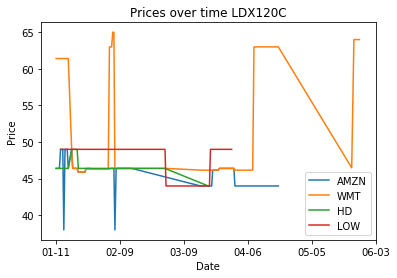

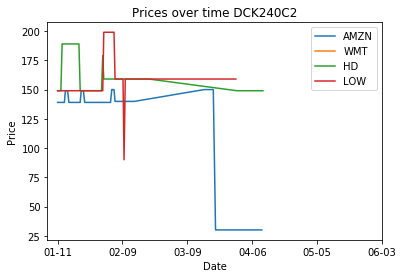

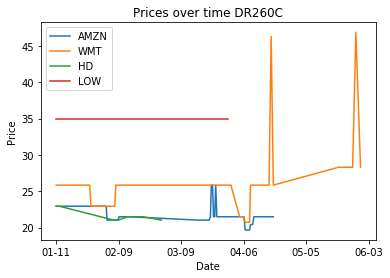

In [15]:
#price matching graphs
models = ['LDX120C','DCK240C2', 'DR260C']

def price_match(model,prices):
    platforms  = ['AMZN','WMT','HD','LOW']
    for plat in platforms:
        prod1_plat = prices[ (prices['platform']==plat) & (prices['model'] == model) ]
        axes = plt.plot(prod1_plat['date'],prod1_plat['price'],label=plat)
        
    xticks =  np.linspace(prices['date'].min(),prices['date'].max(),6)
    xticks = pd.Series(xticks)
    xticklabels =  (xticks/1.0e3).apply(datetime.datetime.fromtimestamp).apply(lambda x: str(x)[5:10] )
    plt.xticks(xticks,xticklabels)  
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title( 'Prices over time %s'%model )
    plt.savefig('figures/%s.png'%model)
    plt.show()
    

for model in models:
    price_match(model,clean_price)

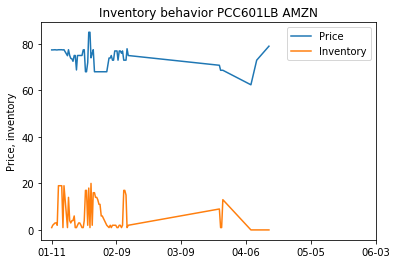

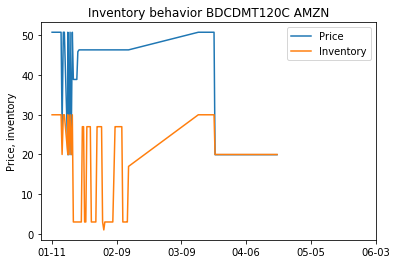

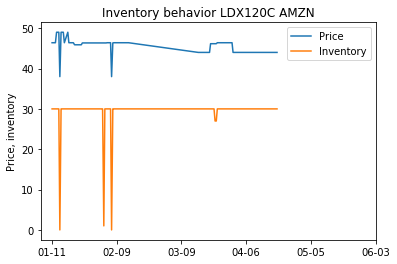

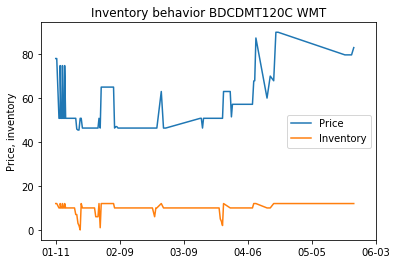

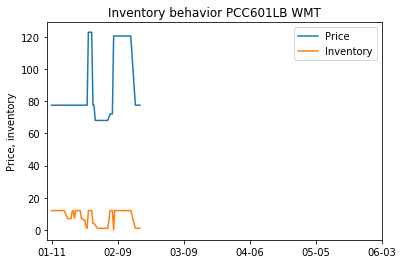

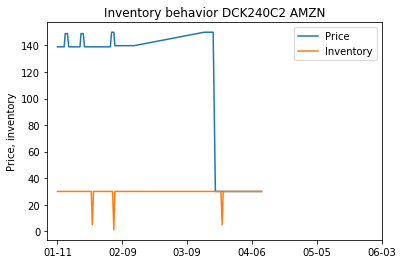

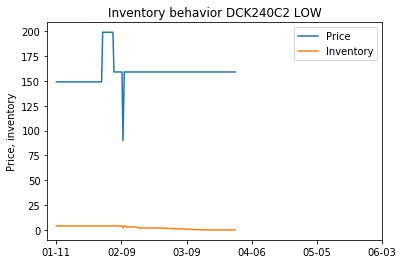

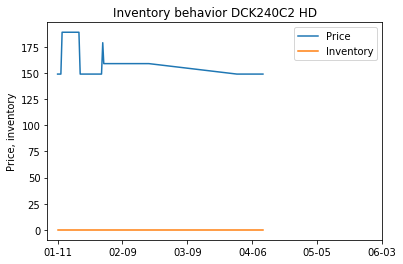

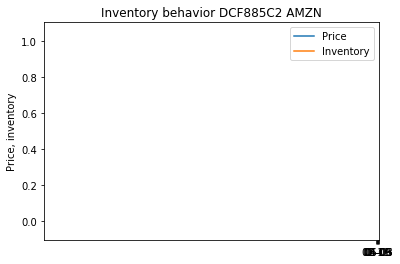

In [13]:
#inventory graphs
invents = [('PCC601LB','AMZN'),('BDCDMT120C','AMZN'),('LDX120C','AMZN'),('BDCDMT120C','WMT'), ('PCC601LB','WMT'), 
           ('DCK240C2','AMZN'), ('DCK240C2','LOW'),('DCK240C2','HD'), ('DCF885C2','AMZN') ]

def sales_plot(model,plat,prices):

    prod1_plat = prices[ (prices['platform']==plat) & (prices['model'] == model) ]
    logify = lambda x : np.log(x+1)
    axes = plt.plot(prod1_plat['date'],(prod1_plat['price']),label='Price')
    axes = plt.plot(prod1_plat['date'],(prod1_plat['inventory']),label='Inventory')
    #axes = plt.plot(prod1_plat['date'],logify(prod1_plat['new_rank']),label='Rank')
        
    xticks =  np.linspace(prices['date'].min(),prices['date'].max(),6)
    xticks = pd.Series(xticks)
    xticklabels =  (xticks/1.0e3).apply(datetime.datetime.fromtimestamp).apply(lambda x: str(x)[5:10] )
    plt.xticks(xticks,xticklabels)  
    plt.legend()
    plt.ylabel('Price, inventory')
    plt.title( 'Inventory behavior %s %s'%(model,plat) )
    plt.savefig('figures/%s_%s.png'%(model, plat))
    plt.show()
    
for (model,plat) in invents:
    sales_plot(model,plat,clean_price)

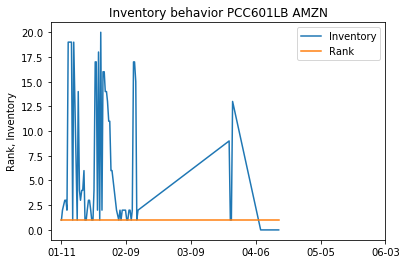

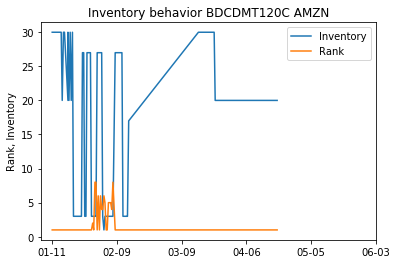

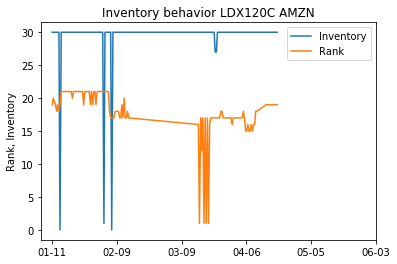

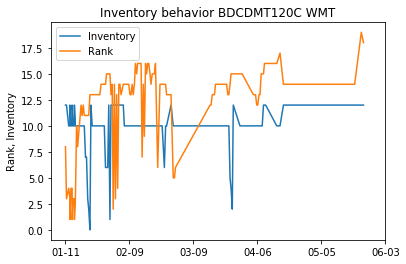

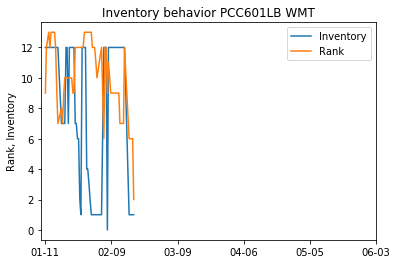

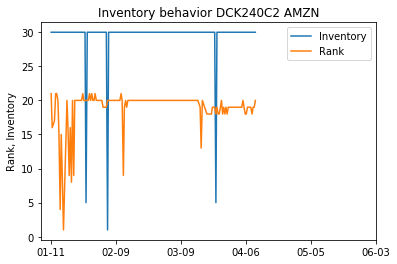

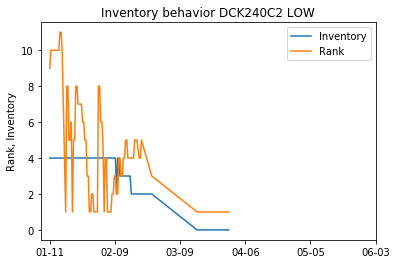

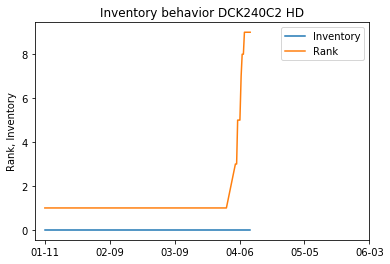

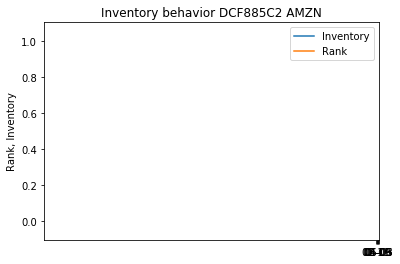

In [14]:
#inventory graphs
invents = [('PCC601LB','AMZN'),('BDCDMT120C','AMZN'),('LDX120C','AMZN'),('BDCDMT120C','WMT'), ('PCC601LB','WMT'), 
           ('DCK240C2','AMZN'), ('DCK240C2','LOW'),('DCK240C2','HD'), ('DCF885C2','AMZN') ]

def sales_plot(model,plat,prices):

    prod1_plat = prices[ (prices['platform']==plat) & (prices['model'] == model) ]
    logify = lambda x : np.log(x+1)
    #axes = plt.plot(prod1_plat['date'],(prod1_plat['price']),label='Price')
    axes = plt.plot(prod1_plat['date'],(prod1_plat['inventory']),label='Inventory')
    axes = plt.plot(prod1_plat['date'], prod1_plat['new_rank'] ,label='Rank')
        
    xticks =  np.linspace(prices['date'].min(),prices['date'].max(),6)
    xticks = pd.Series(xticks)
    xticklabels =  (xticks/1.0e3).apply(datetime.datetime.fromtimestamp).apply(lambda x: str(x)[5:10] )
    plt.xticks(xticks,xticklabels)  
    plt.legend()
    plt.ylabel('Rank, Inventory')
    plt.title( 'Inventory behavior %s %s'%(model,plat) )
    plt.savefig('figures/%s_%s_2.png'%(model, plat))
    plt.show()
    
for (model,plat) in invents:
    sales_plot(model,plat,clean_price)